<a href="https://colab.research.google.com/github/Seyed-Ali-Ahmadi/Python-for-Remote-Sensing/blob/master/Sentinel_1_OWI_product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Requirements**

Working with Sentinel-1 level-2 products requires some packages to be installed on your machine. These packages are:

* Numpy (manipulate with arrays and matrices)
* Cartopy (Advanced geographic plotting)
* NetCDF4 (accessing netcdf file format)
* matplotlib (to handle graphs and plots)
* zipfile (to access the contents of raw Sentinel files)

To install the packages use following two cells (without exclamation marks).

In [0]:
# install NetCDF4 package
!pip install netcdf4

In [0]:
# install Cartopy package
!apt-get -qq install python-cartopy python3-cartopy

In [3]:
import zipfile as zf
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:1879: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


# Data import

OCN-OWI product is located in a subfolder of the .SAFE file which is downloaded from Copernicus web service. To access the OCN products we should first extract the Zip file.

All you need to do is to introduce the zip file name which you download from sentinel-hub to the program.

In [0]:
# Opening the Sentinel-1 OCN product...
file_name = '/content/S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.zip'

with zf.ZipFile(file_name, 'r') as zip:
  # Extract the file in the current directory.
  zip.extractall()
  # Print all containing files and folders.
#   zip.printdir()

In [5]:
# Accessing the OWI sub-product.
nc_file = '/content/S1A_IW_OCN__2SDV_20190718T212220_20190718T212245_028177_032EC9_AF8E.SAFE/measurement/s1a-iw-ocn-vv-20190718t212127-20190718t212159-028177-032EC9-001.nc'
dataset = nc.Dataset(nc_file)

# Just to check what information is stored in the netCDF file.
print(dataset.dimensions.keys())

odict_keys(['rvlRaSize', 'length', 'rvlAzSize', 'rvlSwath', 'owiRaSize', 'owiAzSize', 'owiIncSize', 'owiPolarisation', 'oswRaSize', 'oswAzSize', 'oswWavenumberBinSize', 'oswAngularBinSize', 'oswPartitions', 'oswKxBinSize', 'oswKyBinSize', 'oswLag'])


In [6]:
# Become familiar with the file format.
print(dataset.dimensions['owiAzSize'])
print(dataset.dimensions['owiRaSize'])
print(dataset.dimensions['owiIncSize'])
print(dataset.dimensions['owiPolarisation'])

<class 'netCDF4._netCDF4.Dimension'>: name = 'owiAzSize', size = 166

<class 'netCDF4._netCDF4.Dimension'>: name = 'owiRaSize', size = 255

<class 'netCDF4._netCDF4.Dimension'>: name = 'owiIncSize', size = 152

<class 'netCDF4._netCDF4.Dimension'>: name = 'owiPolarisation', size = 2



Using ```variables``` method we can see what is inside the netCDF file. Besides all OCN products, there exists OWI related data which are latitudes, longitudes, wind speed, wind direction, etc. 

Each variable's details can be obtained through its name.



In [7]:
print(dataset.variables.keys())
print('Wind Speed Data \n', dataset.variables['owiWindSpeed'])
print('Wind Direction Data \n', dataset.variables['owiWindDirection'])

odict_keys(['oswPolSpec', 'oswPartitions', 'oswQualityCrossSpectraRe', 'oswQualityCrossSpectraIm', 'oswK', 'oswPhi', 'oswAzCutoff', 'oswRaCutoff', 'oswSpecRes', 'oswLon', 'oswLat', 'oswHs', 'oswWl', 'oswDirmet', 'oswSnr', 'oswAmbiFac', 'oswIconf', 'oswLookSeparationTime', 'oswNrcs', 'oswInten', 'oswNv', 'oswSkew', 'oswKurt', 'oswWindSpeed', 'oswWindDirection', 'oswEcmwfWindSpeed', 'oswEcmwfWindDirection', 'oswWindSeaHs', 'oswWaveAge', 'oswDepth', 'oswNlWidth', 'oswLandFlag', 'oswLandCoverage', 'oswIncidenceAngle', 'oswHeading', 'oswGroundRngSize', 'oswAziSize', 'oswEllipsLength', 'oswEllipsLengthStdDev', 'oswEllipsWidth', 'oswEllipsWidthStdDev', 'oswGroupDir', 'oswQualityFlagPartition', 'oswQualityFlag', 'oswTotalHs', 'oswCartSpecIm', 'oswCartSpecRe', 'oswKx', 'oswKy', 'oswJx', 'oswJy', 'owiHs', 'owiWl', 'owiDirmet', 'owiWindSeaHs', 'owiLon', 'owiLat', 'owiIncidenceAngle', 'owiElevationAngle', 'owiWindSpeed', 'owiWindDirection', 'owiEcmwfWindSpeed', 'owiEcmwfWindDirection', 'owiNrcs', 

As it is seen above, the fill value, which is used for regions where there is no data, is -999.0. We change this value with NaN to be able to handle the images easily.

The following graphs are just to check the arrays and values within them.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb42300c898>,
 Text(0.5, 1.0, 'OWI Wind Direction'))

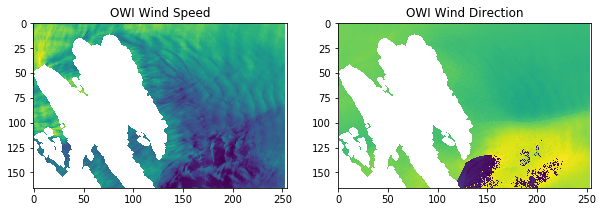

In [8]:
owiSpeed = np.array(dataset.variables['owiWindSpeed'])
owiSpeed[owiSpeed == -999.0] = np.nan

owiDir = np.array(dataset.variables['owiWindDirection'])
owiDir[owiDir == -999.0] = np.nan

fig = plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(owiSpeed, cmap='viridis'), plt.title('OWI Wind Speed')
plt.subplot(122), plt.imshow(owiDir, cmap='viridis'), plt.title('OWI Wind Direction')


To be able to correctly register the image on a projection system, latitudes and longitudes are required which are store in related variables. Change them to array type for further usage.

In [9]:
lat = np.array(dataset.variables['owiLat'])
lon = np.array(dataset.variables['owiLon'])
# the result is the same for lines below...
# lat = dataset.variables['owiLat'][:]
# lon = dataset.variables['owiLon'][:]
print(lat)
print(lon)

[[46.37175  46.37347  46.37519  ... 46.760975 46.762333 46.76369 ]
 [46.380726 46.382446 46.384167 ... 46.769962 46.771324 46.77268 ]
 [46.3897   46.391426 46.393147 ... 46.77895  46.780308 46.781666]
 ...
 [47.835102 47.836838 47.838577 ... 48.224842 48.226196 48.22755 ]
 [47.844074 47.845814 47.84755  ... 48.233818 48.235176 48.23653 ]
 [47.85305  47.85479  47.856525 ... 48.242798 48.244156 48.245506]]
[[-54.10199  -54.089233 -54.076477 ... -50.863705 -50.85076  -50.837822]
 [-54.10455  -54.091793 -54.079033 ... -50.865734 -50.85279  -50.839848]
 [-54.107113 -54.094357 -54.081596 ... -50.867764 -50.85482  -50.841873]
 ...
 [-54.527348 -54.514236 -54.50113  ... -51.198616 -51.185314 -51.17201 ]
 [-54.529995 -54.516884 -54.503773 ... -51.20069  -51.187386 -51.17408 ]
 [-54.532646 -54.519535 -54.50642  ... -51.202766 -51.18946  -51.17615 ]]


# Creating the map
All the magic is happening here.



1.   Create a plot,
2.   set coordinate system for the geographic illustration purposes,
3.   to put every pixel in its correct (lat, lon) coordinate, use the `lat` and `lon` arrays,
4.   colormap can be assigned through `cmap`,
5.   set the title and extents of the map,
6.   use cartopy features to draw coastlines and land regions with proper resolution,
7.   add the colorbar which shows the wind speed values,
8.   calculate dx and dy values from directions of windDirection array. Directions are measured in degrees from North,
9.   finalize the map with corresponding coordinates and gridlines.

Your beautiful map is ready!




/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


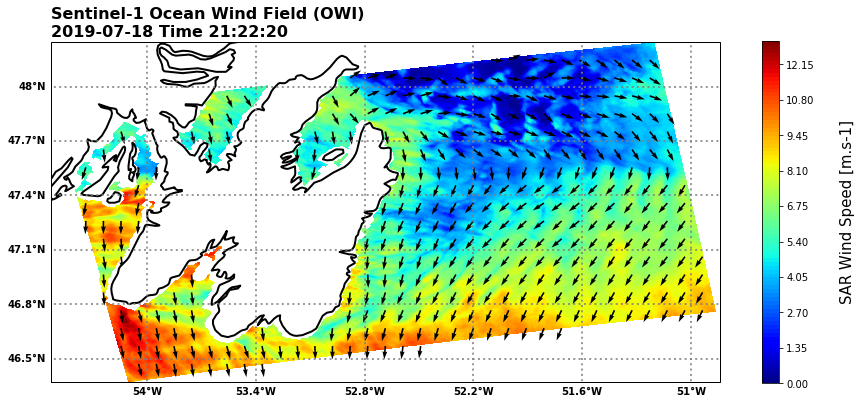

In [10]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=ccrs.PlateCarree())

# Draw Wind Speed Data
carto_map = ax.contourf(lon, lat, owiSpeed, 100, 
                        transform=ccrs.PlateCarree(), 
                        cmap='jet')

title = 'Sentinel-1 Ocean Wind Field (OWI)\n2019-07-18 Time 21:22:20'
ax.set_title(title,
             fontsize=16,
             fontweight='bold',
             loc='left')

# Extents
ax.set_xlim((np.amin(lon), np.amax(lon)))
ax.set_ylim((np.amin(lat), np.amax(lat)))

# Mask land regions and coastlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                            edgecolor='face', facecolor='w'))
ax.coastlines(resolution='10m', linewidth=2, color='black')

# Colorbar
cbar = plt.colorbar(carto_map, shrink=0.42)
cbar.set_label('SAR Wind Speed [m.s-1]',
               fontsize=15, 
               labelpad=25)

# Draw wind speed vectors
dx = np.cos(owiDir * np.pi / 180)  # u
dy = np.sin(owiDir * np.pi / 180)  # v
ax.quiver(lon, lat, dx, dy, angles="xy", color="black", regrid_shape=20)

# Draw gridlines and lat lon ticks on the axis
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.8, linestyle=':')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'color': 'black', 'weight': 'bold', 'size': 10}
gl.ylabel_style = {'color': 'black', 'weight': 'bold', 'size': 10}